In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.cluster import KMeans
import seaborn as sns
from sklearn.model_selection import train_test_split
%matplotlib inline

In [2]:
plt.rcParams["font.size"] = 18
plt.rcParams["axes.grid"] = True
plt.rcParams["figure.figsize"] = 12,8
plt.rcParams['font.serif'] = "Cambria"
plt.rcParams['font.family'] = "serif"

In [3]:
dataset2 = pd.read_csv('function1_2d.csv',index_col = 0)

In [4]:
def f(ds,n_clu):
    
    n_feat = ds.shape[1]-1
    X = ds.iloc[:,:n_feat]
    cluster_centers_list = []
    label_list = []
    kmeans = KMeans(n_clusters=n_clu, random_state=42).fit(X.to_numpy())
    label_list.append(kmeans.labels_)
    cluster_centers_list.append(kmeans.cluster_centers_)  

    mean_centers = cluster_centers_list[-1]
    corresponding_center = mean_centers[label_list[-1],:]

    X = X.to_numpy()
    distance = np.linalg.norm(X-corresponding_center, axis=1)
    var = np.var(distance)*distance.size
    #print(var)
    
    phi = np.ones((X.shape[0], 1))
    for i in range(n_clu):
        A = X-mean_centers[i,:]
        A = np.exp(-np.linalg.norm(X-mean_centers[i,:], axis=1)**2/var)
        #print(np.linalg.norm(X-mean_centers[i,:], axis=1)**2)
        phi = np.append(phi, np.exp(-np.linalg.norm(X-mean_centers[i,:], axis=1)**2/var).reshape(-1,1), axis=1)
    #lmbda = 1
    return(phi,mean_centers,var)


In [5]:
def tikhonov_reg(phi,mu,sigma,l):
    K = len(mu)
    phiT = np.zeros((K+1,K+1))
    phiT[0,0] = 1
    for i in range(1,K+1):
        for j in range(1,K+1):
            phiT[i,j] = np.exp(-(np.linalg.norm(mu[i-1]-mu[j-1])**2)/sigma**2)
    #l = 300
    #print(phiT.shape)
    pinv = np.linalg.inv(phi.T @ phi+l*phiT) @ phi.T
    return(pinv)

In [6]:
# hyperparameters: no. of clusters, is sigma also?
# assuming sigma of the range of norm(x - mu)
# training for different no. of clusters and trying on CV set
train, test = train_test_split(dataset2,test_size = 0.2,random_state = 0)
train, cv = train_test_split(train,test_size = 0.1,random_state = 0)

In [7]:
n_clusters = list(range(1,26))

In [8]:
X_cv = cv.iloc[:,:2]

In [71]:
# no regularization
sse_train = []
sse_cv = []
sse_test = []
train_pred = []
cv_pred = []
test_pred = []
for clu in n_clusters:
    phi_train, centers, sig = f(train,clu)
    params = tikhonov_reg(phi_train,centers,sig,0) @ train.iloc[:,2]
    phi_cv = np.ones((X_cv.shape[0], 1))
    phi_test = np.ones((X_test.shape[0], 1))
    
    for i in range(clu):
        phi_cv = np.append(phi_cv, np.exp(-np.linalg.norm(X_cv-centers[i,:], axis=1)**2/sig).reshape(-1,1), axis=1)
        phi_test = np.append(phi_test, np.exp(-np.linalg.norm(X_test-centers[i,:], axis=1)**2/sig).reshape(-1,1), axis=1)
    y_train = phi_train @ params
    y_cv = phi_cv @ params
    y_test = phi_test @ params
    sse_train.append(np.linalg.norm(y_train-train["y"]))
    sse_cv.append(np.linalg.norm(y_cv-cv["y"]))
    sse_test.append(np.linalg.norm(y_test - test["y"]))

    train_pred.append(y_train)
    cv_pred.append(y_cv)
    test_pred.append(y_test)

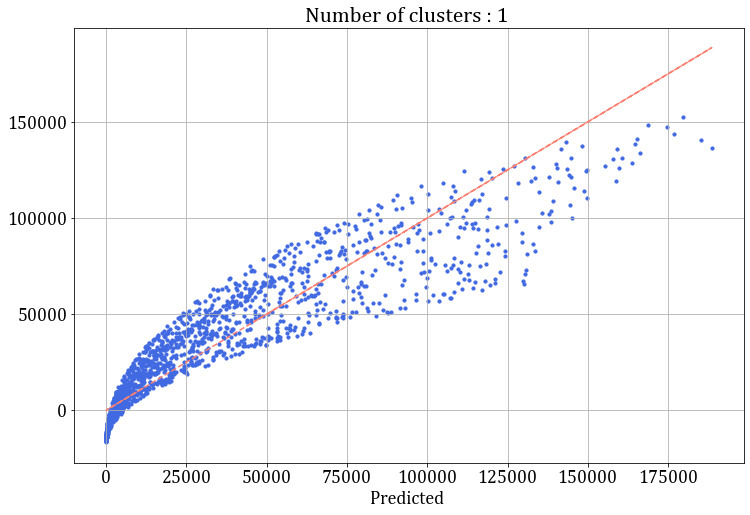

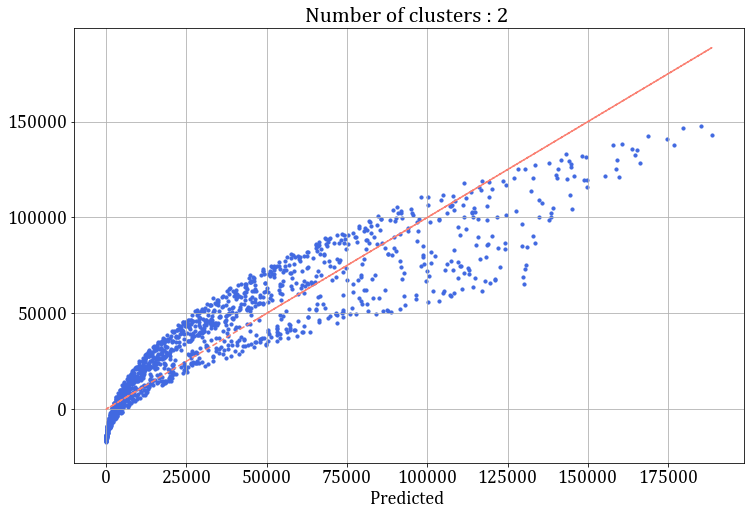

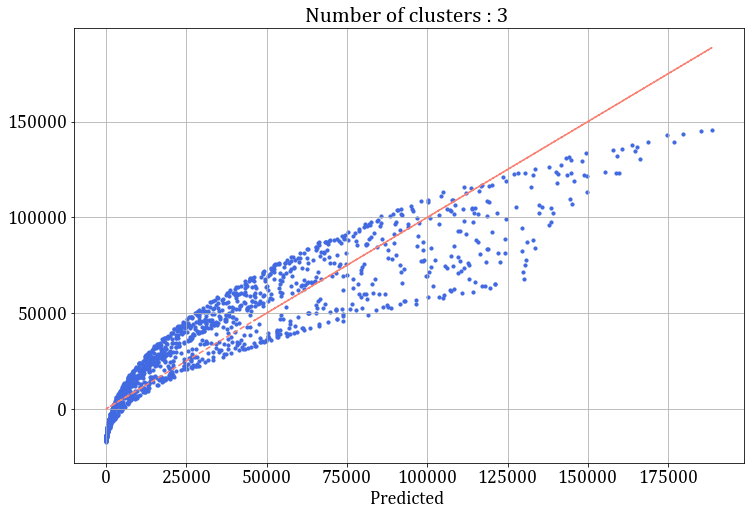

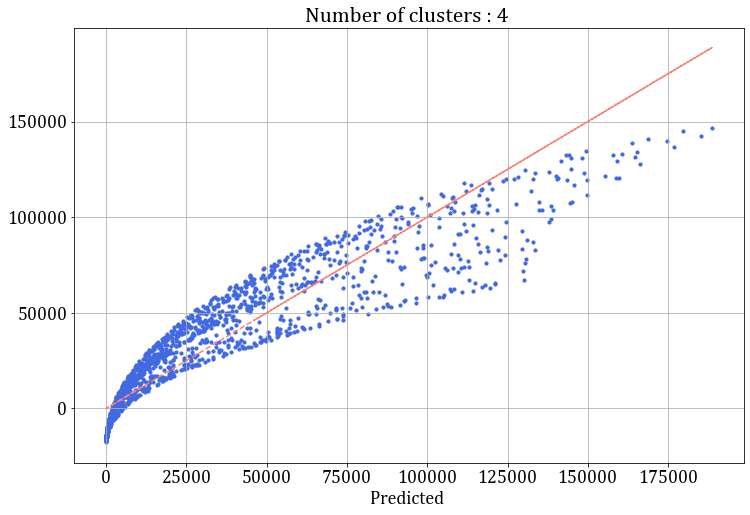

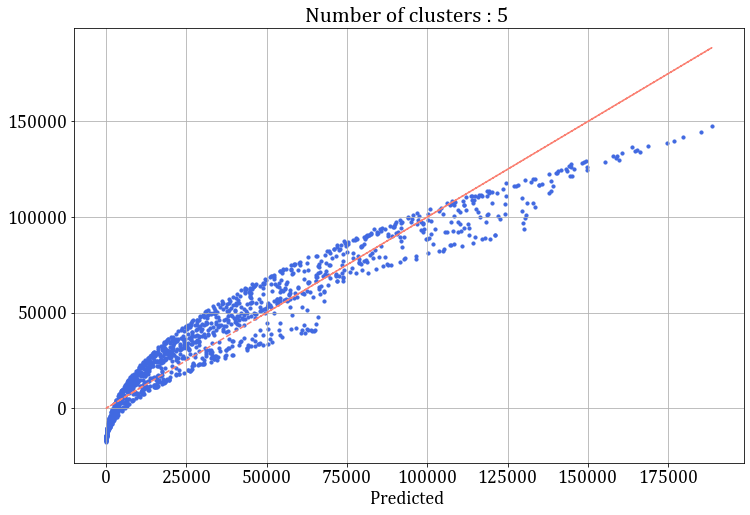

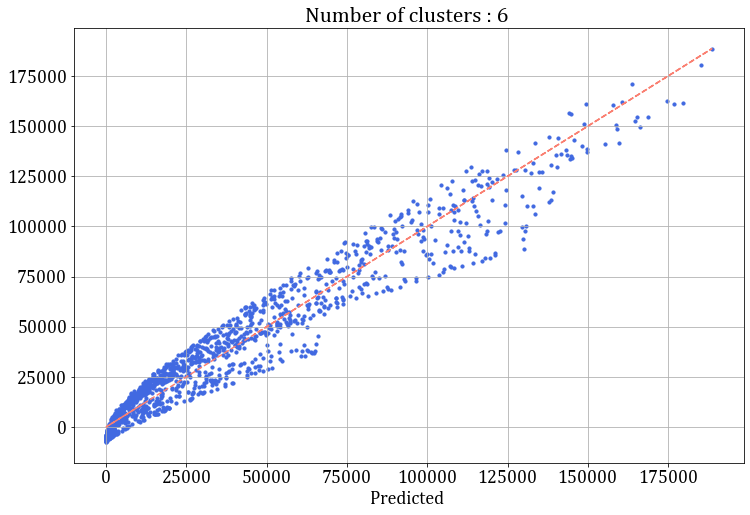

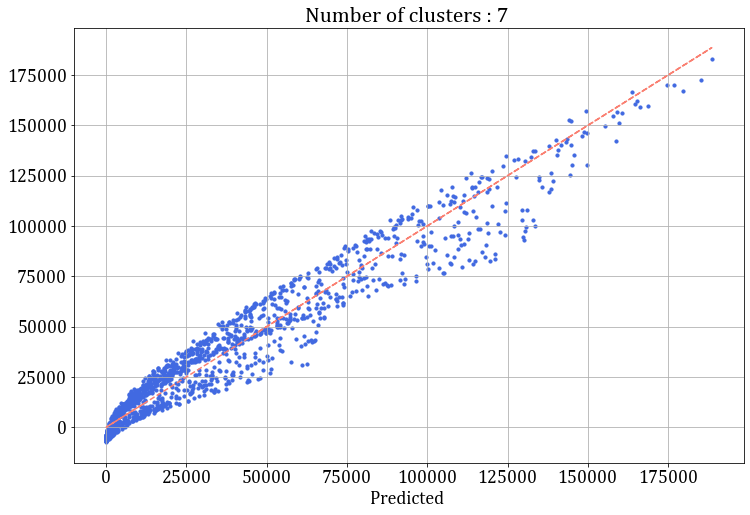

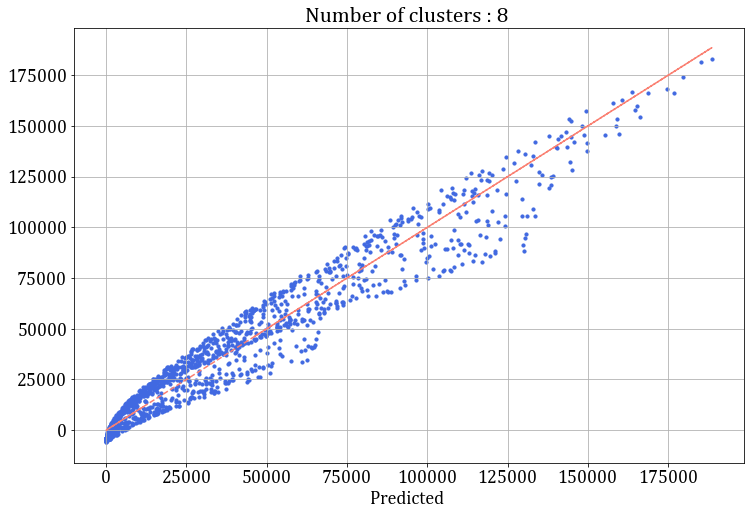

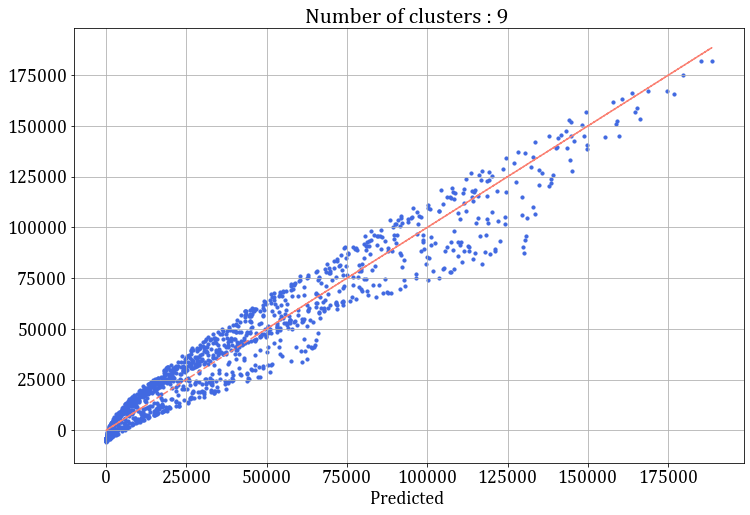

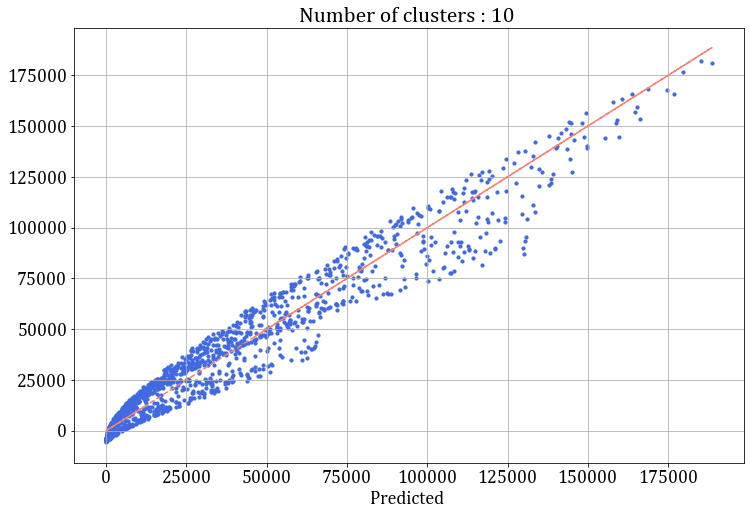

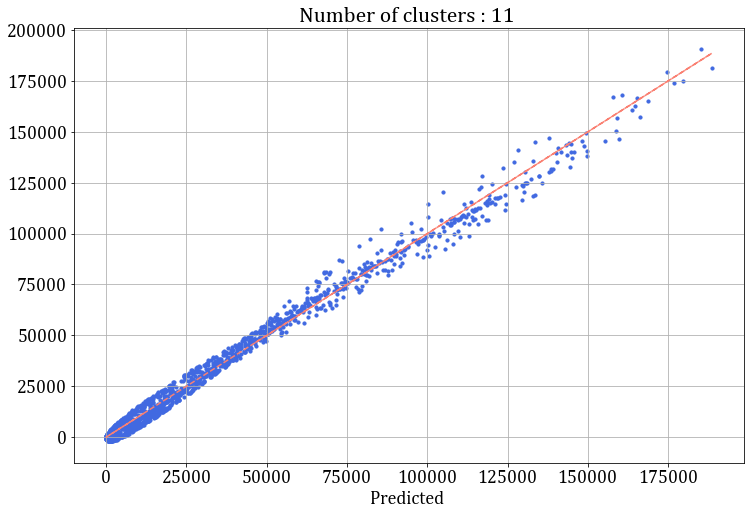

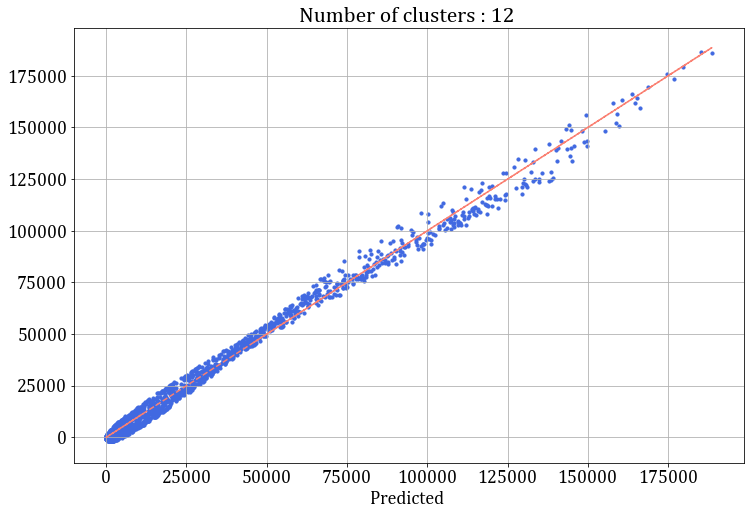

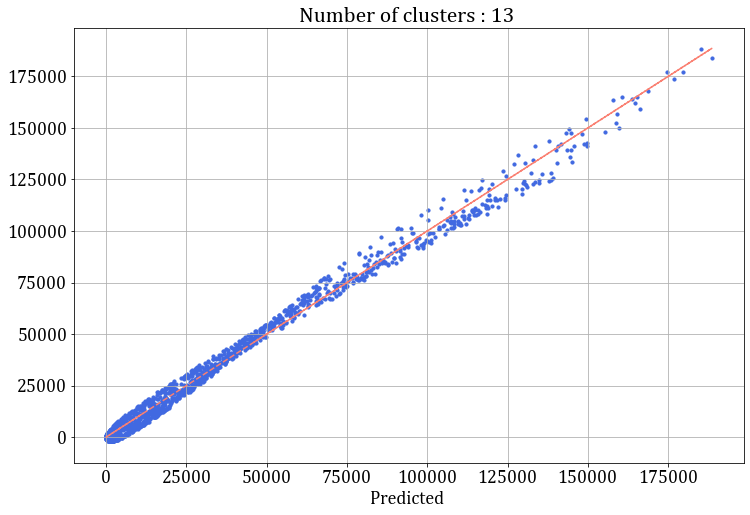

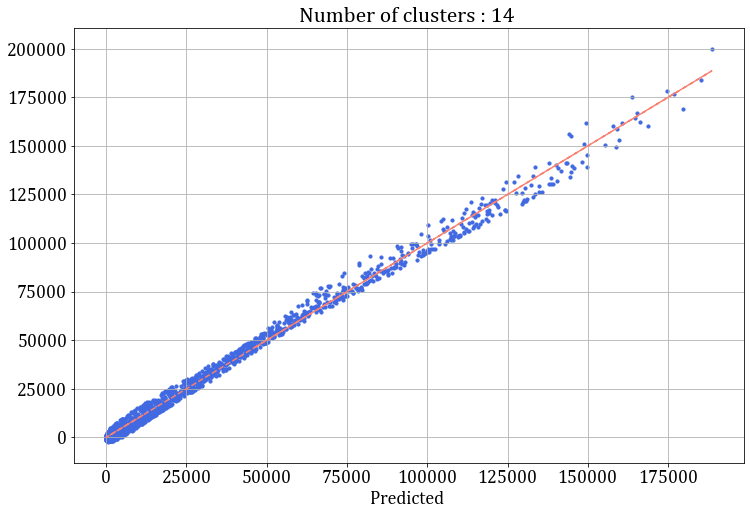

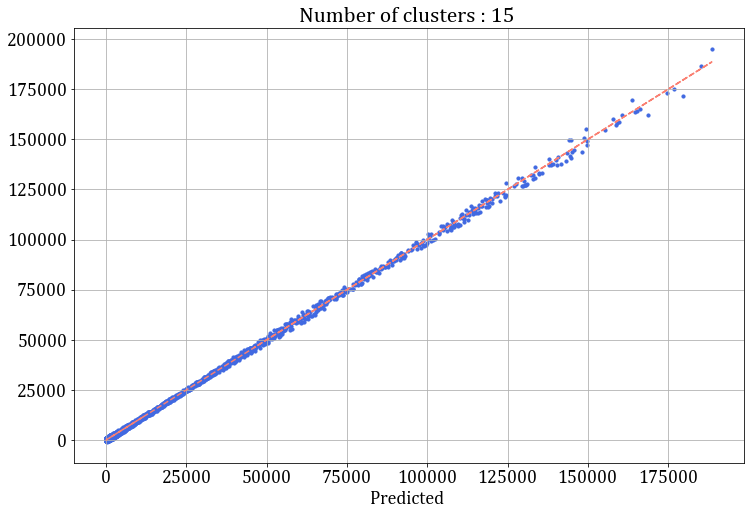

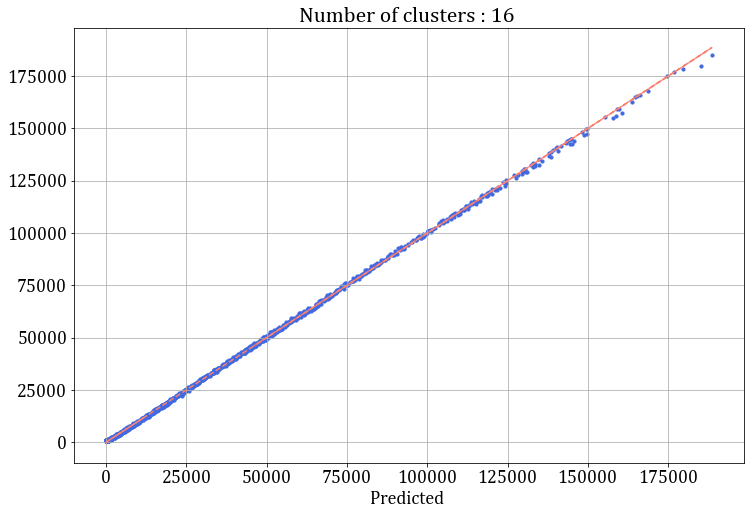

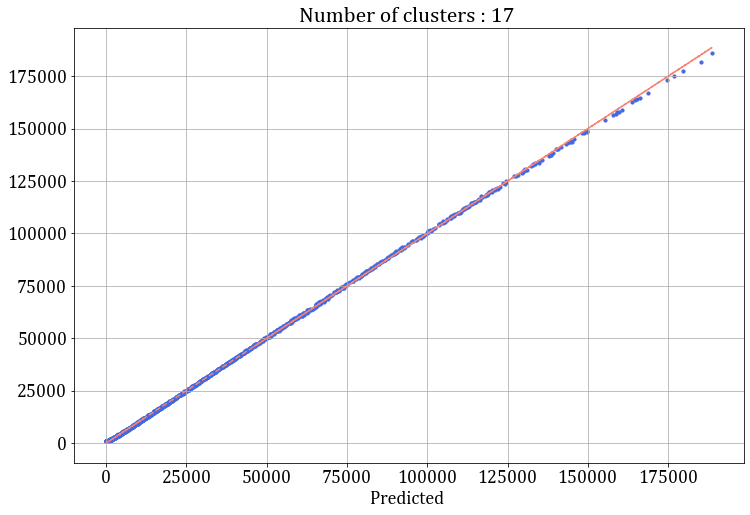

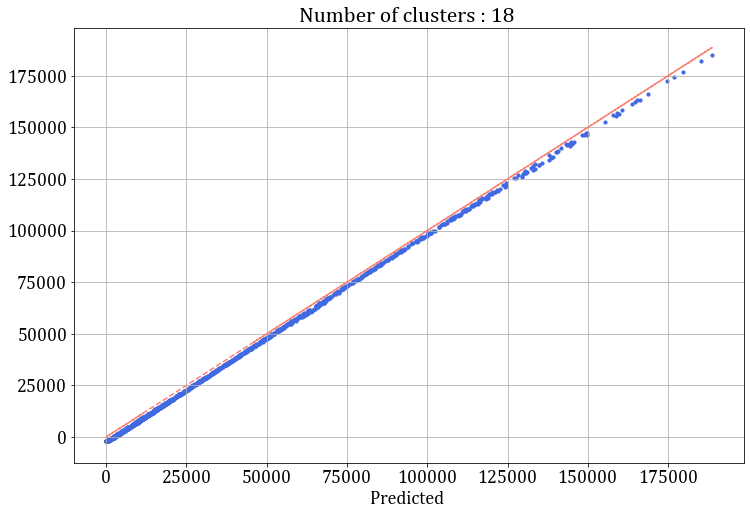

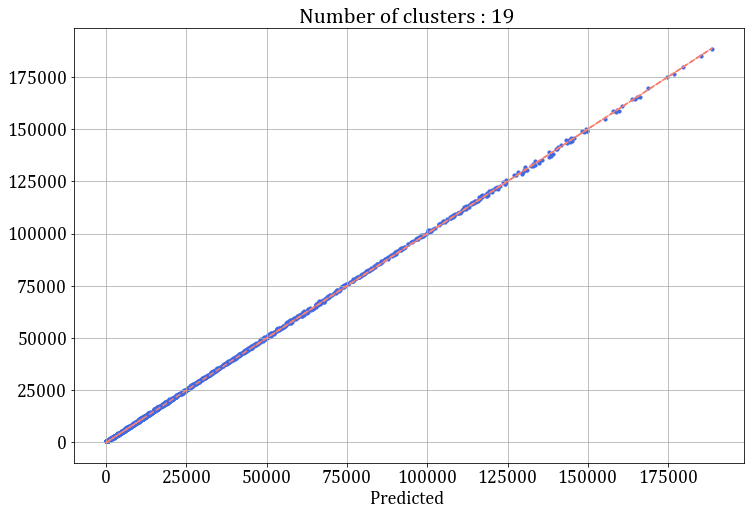

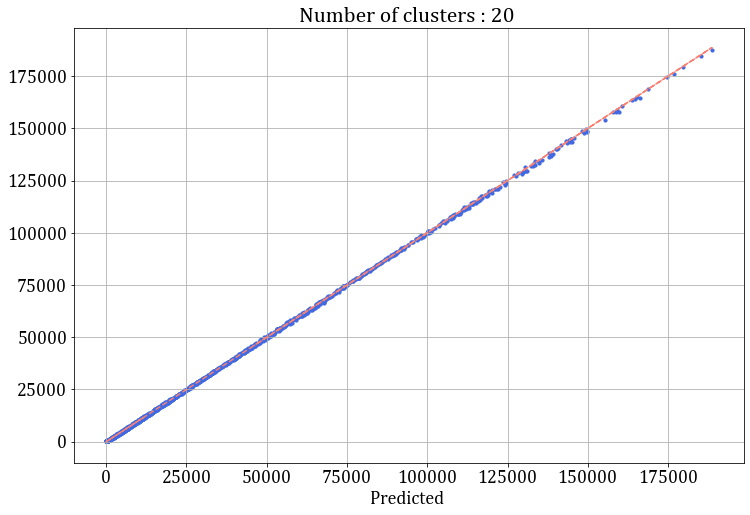

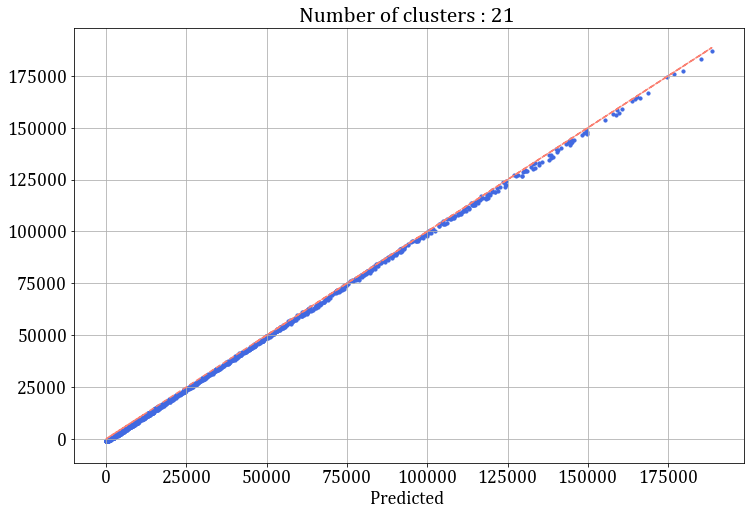

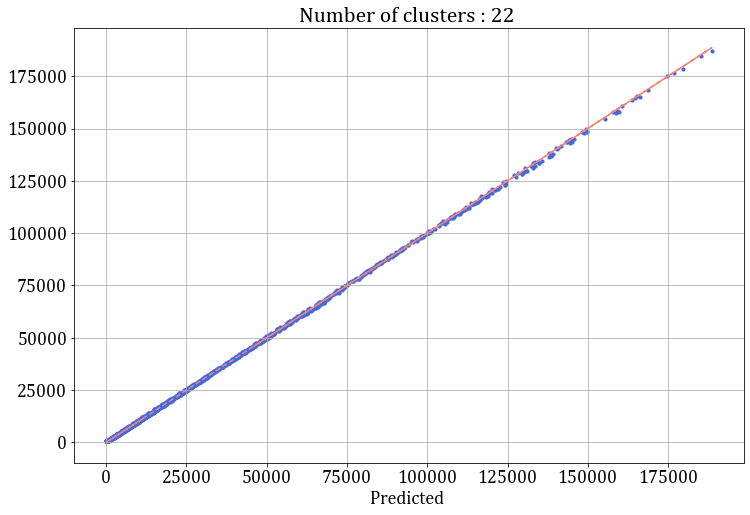

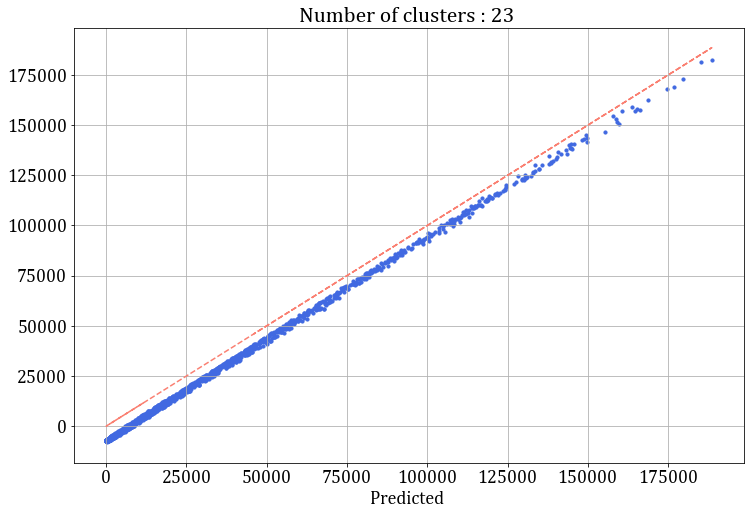

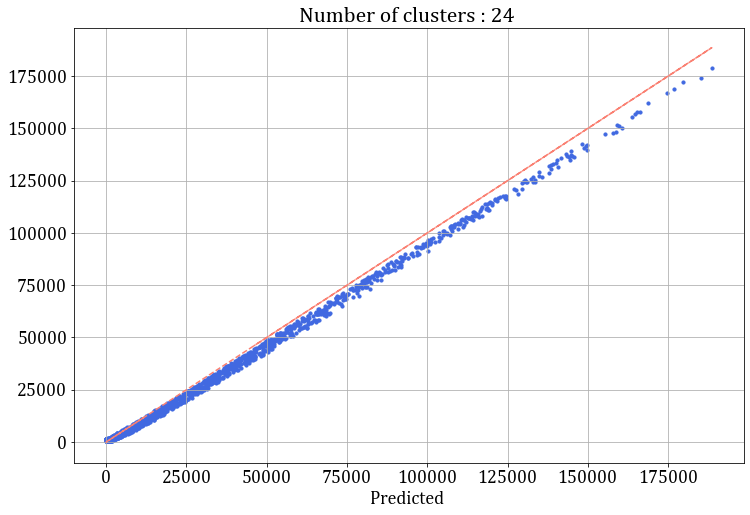

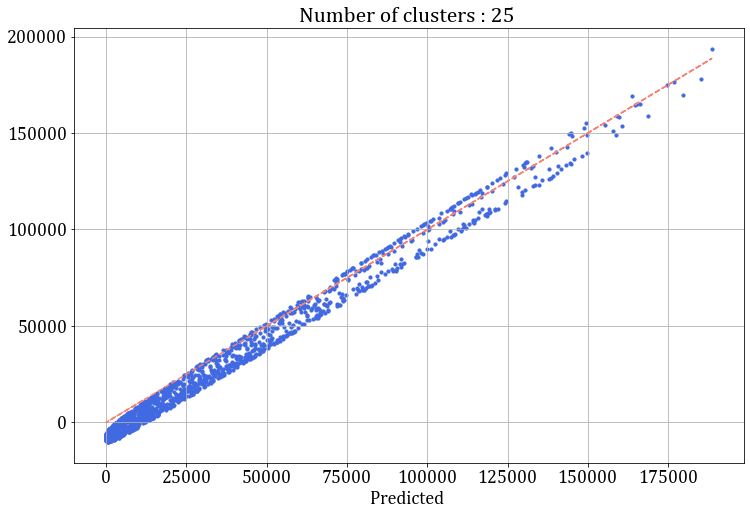

In [10]:
for i in range(len(n_clusters)):
    plt.plot(train["y"],train["y"],color = "salmon",linestyle = "dashed")
    plt.scatter(train["y"],train_pred[i],s = 10, color = "royalblue")
    #plt.plot(np.linspace(0,175000))
    plt.title(f"Number of clusters : {i+1} ")
    plt.xlabel("Predicted ")
    plt.show()

In [72]:
sse_train = np.array(sse_train)/len(sse_train)
sse_cv = np.array(sse_cv)/len(sse_cv)
sse_test = np.array(sse_test)/len(sse_test)

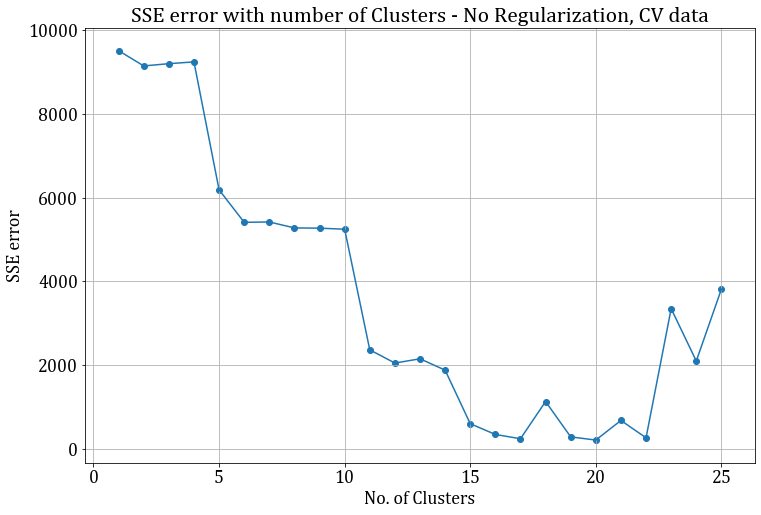

In [24]:
plt.plot(n_clusters,sse_cv)
plt.scatter(n_clusters,sse_cv)
plt.xlabel("No. of Clusters")
plt.ylabel("SSE error")
plt.title("SSE error with number of Clusters - No Regularization, CV data")
plt.savefig("errorplot_ds2_no_reg.png")
plt.show()

In [73]:
dict_ = {"Number of Clusters":n_clusters, "Training Error":sse_train, "CV error":sse_cv, "Test error": sse_test}
df = pd.DataFrame(dict_)
df = df.round(decimals = 2)


In [27]:
n_clusters[np.argmin(np.array(df["CV error"]))]

20

In [74]:
df.to_csv("error_ds2_noreg.csv")

In [76]:
df

,Number of Clusters,Training Error,CV error,Test error
0,1,24162.18,9515.08,13461.11
1,2,23366.64,9149.58,12873.64
2,3,23356.33,9203.65,12956.92
3,4,23459.03,9245.98,13009.79
4,5,16892.92,6189.10,8918.64
5,6,14216.40,5412.48,8203.34
6,7,14112.21,5420.39,8280.16
7,8,13748.40,5278.88,8001.02
8,9,13754.34,5272.51,7966.53
9,10,13680.91,5247.02,7893.35


In [ ]:
#  choosing 20 clusters

In [29]:
X_test = test.iloc[:,:2]

In [30]:
phi_train, centers, sig = f(train,20)
params = tikhonov_reg(phi_train,centers,sig,0) @ train.iloc[:,2]
phi_test = np.ones((X_test.shape[0], 1))
for i in range(20):
    phi_test = np.append(phi_test, np.exp(-np.linalg.norm(X_test-centers[i,:], axis=1)**2/sig).reshape(-1,1), axis=1)
train_pred=phi_train @ params
test_pred=phi_test @ params

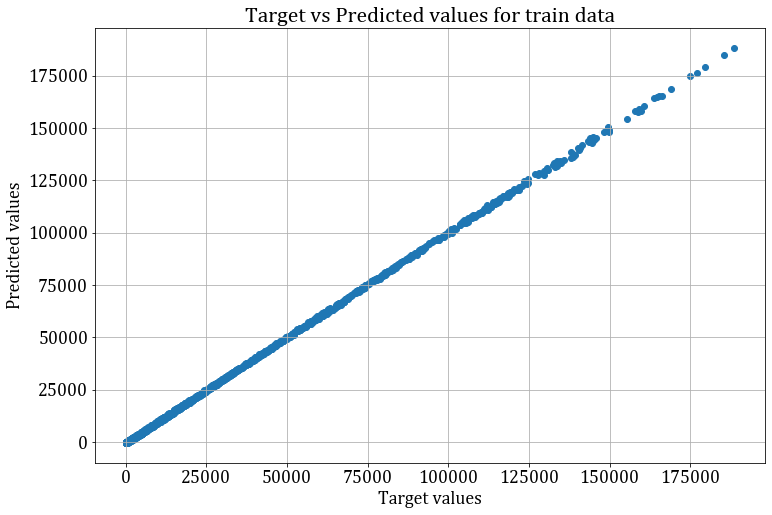

In [37]:
plt.scatter(train["y"],train_pred)
plt.xlabel("Target values")
plt.ylabel("Predicted values")
plt.title("Target vs Predicted values for train data")
plt.savefig("train_ds2_noreg.png")
plt.show()

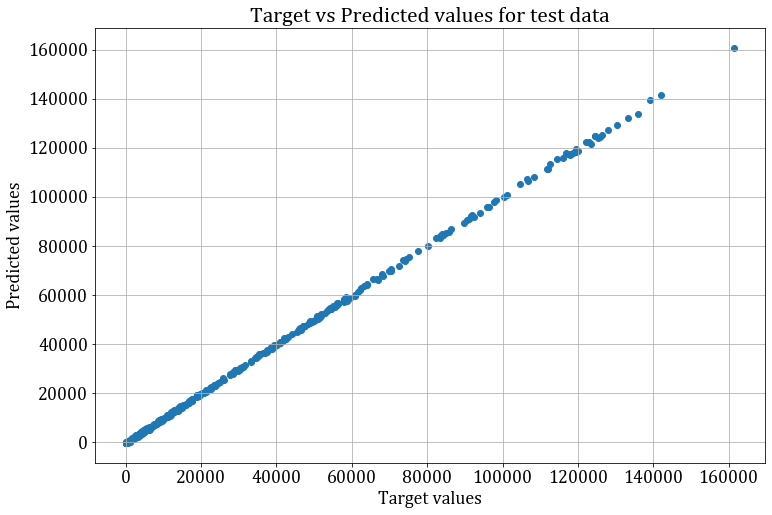

In [36]:
plt.scatter(test["y"],test_pred)
plt.xlabel("Target values")
plt.ylabel("Predicted values")
plt.title("Target vs Predicted values for test data")
plt.savefig("test_ds2_noreg.png")
plt.show()

In [ ]:
x1 = x2 = np.arange(-16,16,0.05)
X1, X2 = np.meshgrid(x1,x2)
arr = np.zeros((X1.ravel().shape[0],2))
arr[:,0] = X1.ravel()
arr[:,1] = X2.ravel()
phi_arr = np.ones((arr.shape[0], 1))
for i in range(20):
    phi_arr = np.append(phi_arr, np.exp(-np.linalg.norm(arr-centers[i,:], axis=1)**2/sig).reshape(-1,1), axis=1)
Z = phi_arr @ params
Z = Z.reshape(X1.shape)

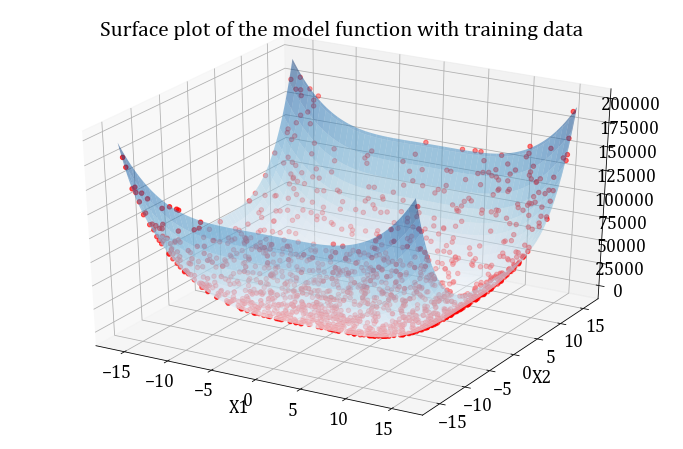

In [82]:
fig = plt.figure()

ax = fig.add_subplot(111,projection = "3d")
ax.scatter(train["x1"],train["x2"],train["y"], color = "red",marker = "o")
ax.plot_surface(X1,X2,Z, cmap = "Blues", alpha = 0.5)
ax.set_xlabel("X1")
ax.set_ylabel("X2")
ax.set_title("Surface plot of the model function with training data")
plt.show()


In [79]:
lambda_list = [0.0,0.001,0.01,0.1,1,10,100,1000]

In [80]:
# tikhonov regularization
sse_train = []
sse_cv = []
sse_test = []
train_pred = []
cv_pred = []
test_pred = []
for l in lambda_list:
    phi_train, centers, sig = f(train,20)
    params = tikhonov_reg(phi_train,centers,sig,l) @ train.iloc[:,2]
    phi_cv = np.ones((X_cv.shape[0], 1))
    phi_test = np.ones((X_test.shape[0], 1))
    
    for i in range(20):
        phi_cv = np.append(phi_cv, np.exp(-np.linalg.norm(X_cv-centers[i,:], axis=1)**2/sig).reshape(-1,1), axis=1)
        phi_test = np.append(phi_test, np.exp(-np.linalg.norm(X_test-centers[i,:], axis=1)**2/sig).reshape(-1,1), axis=1)
    y_train = phi_train @ params
    y_cv = phi_cv @ params
    y_test = phi_test @ params
    sse_train.append(np.linalg.norm(y_train-train["y"]))
    sse_cv.append(np.linalg.norm(y_cv-cv["y"]))
    sse_test.append(np.linalg.norm(y_test-test["y"]))

    train_pred.append(y_train)
    cv_pred.append(y_cv)
    test_pred.append(y_test)

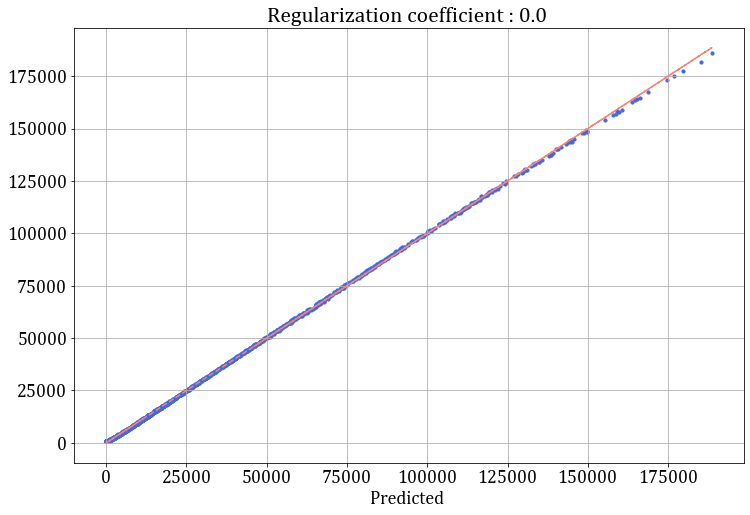

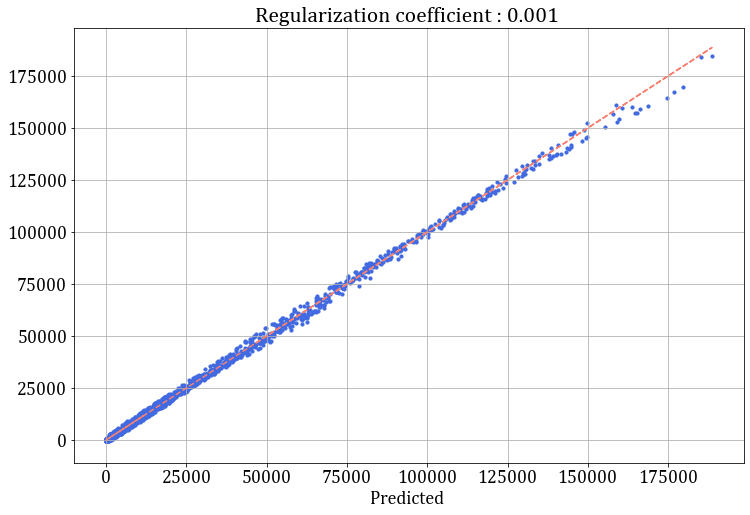

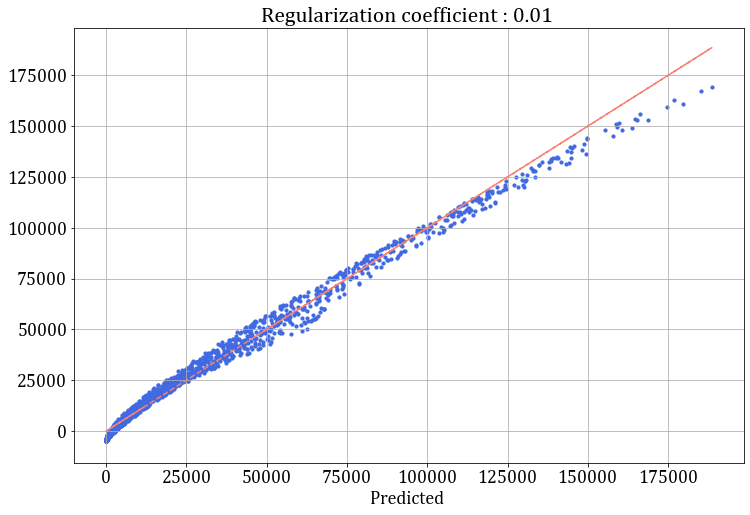

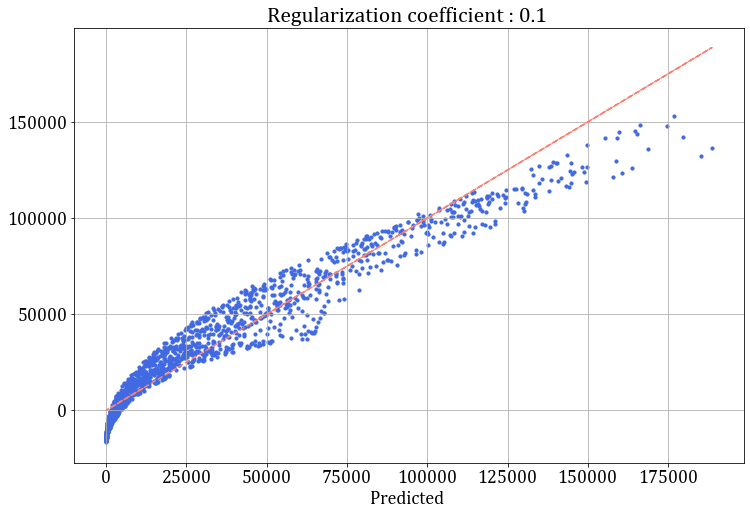

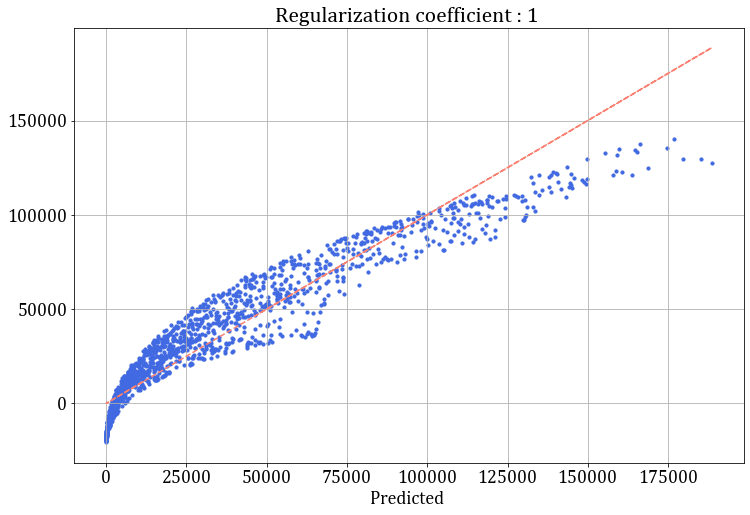

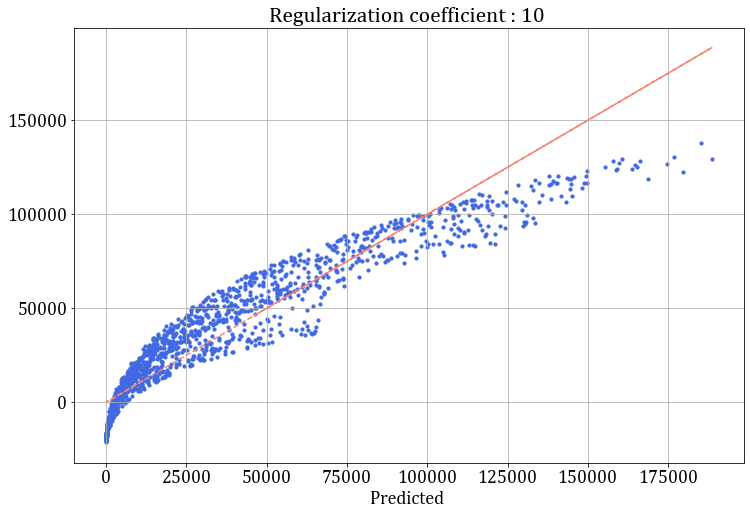

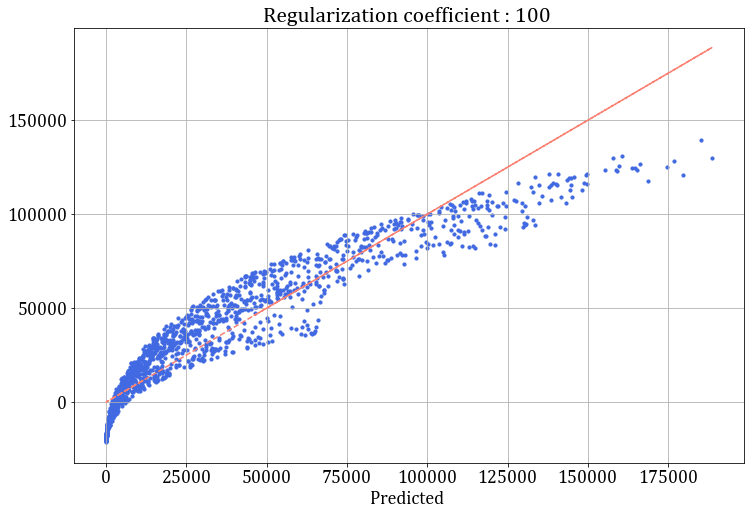

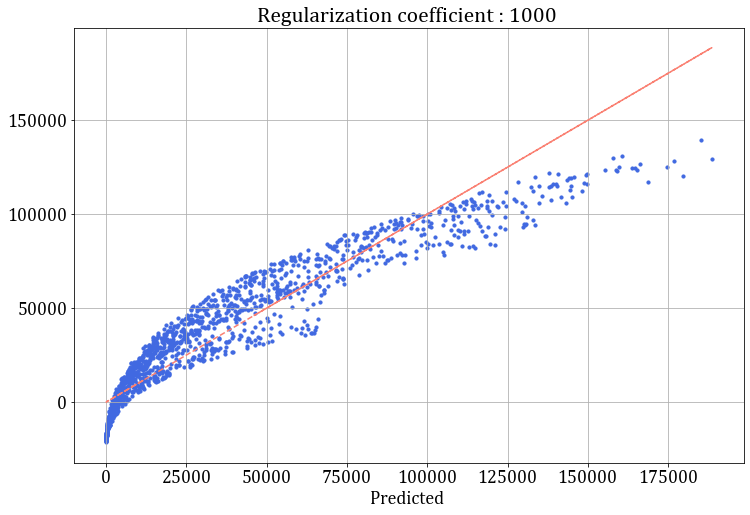

In [45]:
for i in range(len(lambda_list)):
    plt.plot(train["y"],train["y"],color = "salmon",linestyle = "dashed")
    plt.scatter(train["y"],train_pred[i],s = 10, color = "royalblue")
    plt.title(f"Regularization coefficient : {lambda_list[i]} ")
    plt.xlabel("Predicted ")
    plt.show()

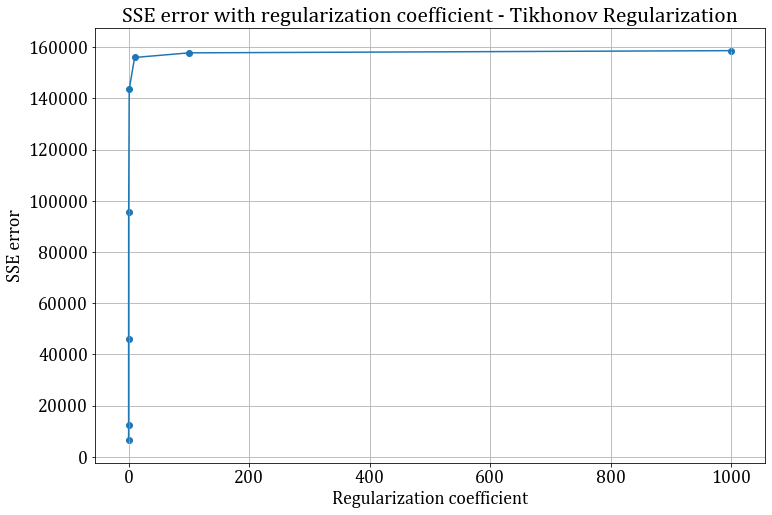

In [83]:
plt.plot(lambda_list,sse_cv)
plt.scatter(lambda_list,sse_cv)
plt.xlabel("Regularization coefficient")
plt.ylabel("SSE error")
plt.title("SSE error with regularization coefficient - Tikhonov Regularization")
plt.savefig("tikh_ds2.png")
plt.show()

In [84]:
dict_ = {"Lambda value":lambda_list, "Training Error":sse_train, "CV error":sse_cv, "Test error":sse_test}
df = pd.DataFrame(dict_)
df = df.round(decimals = 3)

In [86]:
df.to_csv("Tikhonov_ds2_error.csv")

In [85]:
df

,Lambda value,Training Error,CV error,Test error
0,0.000,17494.019,6532.407,9071.453
1,0.001,36844.942,12363.163,18488.443
2,0.010,120061.989,46036.976,63273.457
3,0.100,261409.995,95447.964,141102.858
4,1.000,409864.713,143555.644,220281.197
5,10.000,448860.918,155959.155,240964.611
6,100.000,453429.361,157767.068,243413.628
7,1000.000,455015.669,158631.750,244985.549
